# Objetivo: Previsão de pacientes na UTI (COVID-19)

Utilizarei a base de dados do Hospital Sírio Libanês. A base de dados esta disponível no site do [Kaggle](https://www.kaggle.com/) na pagina do grupo do Sírio Libanês [COVID-19 - Clinical Data to assess diagnosis](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19).

Essa base de dados contém informações, não sensíveis, que diz respeito a quantidade de pacientes que foram ou não internados por covid-19 na clínica do hospital durante a pandemia de corona virus. As informações são ricas com respeito ao quadro clínico e a pergunta que vamos tentar responder é: 

> **Dado um novo paciente conseguiremos prever a chance dele ser encaminhado para a UTI?**


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

# Importação dos dados e pre processamento

In [2]:
sirio_libanes = pd.read_excel('https://github.com/ConradBitt/BootCamp_DataScience/blob/master/ML%20em%20Saude/dados/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true')
sirio_libanes.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


In [3]:
def preenche_tabela(dados):
    features_categoricas = dados.iloc[:, :13]
    saida = dados.iloc[:,-2:]
    colunas_features_continuas = dados.iloc[:,13:-2].columns
    features_continuas = dados.groupby('PATIENT_VISIT_IDENTIFIER')[colunas_features_continuas].fillna(method='backfill').fillna(method='ffill')
    dados_limpos = pd.concat([features_categoricas, features_continuas, saida], axis=1)
    dados_limpos.columns = dados.columns
    return dados_limpos

In [4]:
dados_limpos = preenche_tabela(sirio_libanes)

Dentre as features dentro do dataframe `x` temos a coluna `AGE_PERCENTIL` que indica se a pessoa faz parte do conglomerado, por exemplo, de até 10 anos.

In [5]:
dados_limpos.AGE_PERCENTIL.unique()

array(['60th', '90th', '10th', '40th', '70th', '20th', '50th', '80th',
       '30th', 'Above 90th'], dtype=object)

Esse dado é quantitativo ordinal, isso porque uma pessoa de até 10 anos é mais nova do que uma pessoa até 40 anos.

O módulo `SKLearn` na classe de preprocessamento tem uma transformação chamada `Labelencoder()`. Esta função basicamente pega as categorias e atribui valores numéricos a cada uma delas. Por exemplo, a função `dados_limpos.AGE_PERCENTIL.unique()` retorna as categorias, logo o método `fit_transform()` de um objeto da classe `LabelEncoder()` ira retornar um array com cada categoria:

In [6]:
from sklearn import preprocessing

In [7]:
pd.get_dummies(dados_limpos.AGE_PERCENTIL.unique())

,10th,20th,30th,40th,50th,60th,70th,80th,90th,Above 90th
0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0
5,0,1,0,0,0,0,0,0,0,0
6,0,0,0,0,1,0,0,0,0,0
7,0,0,0,0,0,0,0,1,0,0
8,0,0,1,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,1


In [8]:
print(f'Antes:\n{dados_limpos.AGE_PERCENTIL.unique()}')
le = preprocessing.LabelEncoder()
le.fit(dados_limpos.AGE_PERCENTIL)
dados_limpos.AGE_PERCENTIL = le.fit_transform(dados_limpos.AGE_PERCENTIL)
print(f'\nDepois:\n{dados_limpos.AGE_PERCENTIL.unique()}')

Antes:
['60th' '90th' '10th' '40th' '70th' '20th' '50th' '80th' '30th'
 'Above 90th']

Depois:
[5 8 0 3 6 1 4 7 2 9]


Note que o numero atribuido a cada classe não precisa ter necessariamente um peso, pode ser simplesmente um numero aleatório. Mas no caso do `LabelEncoder()` o numero vem da ordenação das strings

O pandas tem um método chamado `astype()` que muda tipo da variável. Neste método pode-se passar um parâmetro `category` assim ele vai ver quais categorias absolutas (por exemplo o retorno do método `.unique()`) e o índice será o valor da categoria. Veja que o retorno do método `unique()` é um array com 10 elementos, então o método `astype('category')` irá retornar 9 categorias de 0 a 9, cada uma atribuida aos 10 elementos:

In [9]:
dados_limpos.AGE_PERCENTIL = dados_limpos.AGE_PERCENTIL.astype('category').cat.codes

Note que o primeiro elemento tem `60th` e a categoria dele é o $0$, 

In [10]:
dados_limpos.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-0.389967,0.407558,-0.230462,0.096774,-1.000000,-1.000000,4-6,0
3,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-0.389967,0.407558,-0.230462,0.096774,-1.000000,-1.000000,6-12,0
4,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


Note acima que o resultado da feature `AGE_PERCENTIL` não é mais do tipo $90$th, agora é uma variável categórica.

In [11]:
dados_limpos.query('WINDOW == "0-2" and ICU == 1')

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
5,1,1,8,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
85,17,0,3,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
135,27,1,5,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
205,41,1,6,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.666667,-0.858586,-0.689777,-0.399526,-0.891572,-1.000000,-0.663881,-0.858709,0-2,1
235,47,0,4,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
240,48,0,5,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
270,54,1,5,0,0.0,0.0,1.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-0.890980,-0.841512,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
310,62,1,6,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
425,85,1,6,0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.809524,-0.959596,-1.000000,-1.000000,-0.926209,-1.000000,-0.805768,-0.959631,0-2,1
450,90,0,4,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1


In [12]:
identificador_dos_pacientes_a_remover = dados_limpos.query('WINDOW == "0-2" and ICU == 1')['PATIENT_VISIT_IDENTIFIER'].values
dados_limpos = dados_limpos.query(f'PATIENT_VISIT_IDENTIFIER not in "{identificador_dos_pacientes_a_remover.tolist}"')

dados_limpos.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1925.000000,1925.000000,1925.000000,1925.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,...,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000,1925.000000
mean,192.000000,0.467532,4.319481,0.368831,0.108333,0.028125,0.097917,0.019792,0.128125,0.046875,...,-0.758319,-0.811824,-0.910237,-0.817464,-0.758728,-0.848568,-0.771306,-0.812740,-0.910107,0.267532
std,111.168431,0.499074,2.867348,0.482613,0.310882,0.165373,0.297279,0.139320,0.334316,0.211426,...,0.433037,0.296595,0.255396,0.301522,0.389168,0.246814,0.400915,0.295435,0.256035,0.442787
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,96.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,192.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
75%,288.000000,1.000000,7.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.705882,-0.690476,-0.919192,-0.704088,-0.613423,-0.764790,-0.732494,-0.692177,-0.918403,1.000000
max,384.000000,1.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
def prepare_window(rows):
    # se ao longo da coluna ['ICU'] tiver algum valor:
    if (np.any(rows['ICU'])):
        rows.loc[rows['WINDOW'] == '0-2', 'ICU'] = 1
    return rows.loc[rows['WINDOW'] == '0-2']

In [14]:
dados_limpos = dados_limpos.groupby('PATIENT_VISIT_IDENTIFIER').apply(prepare_window)

dados_limpos.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
1,5,1,1,8,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
3,15,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0-2,0


# Separando dados Treino e Teste

In [15]:
colunas_quantitativas = dados_limpos.columns

sirio_libanes_quantitativos = dados_limpos[colunas_quantitativas].dropna()
sirio_libanes_quantitativos.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 384 entries, (0, 0) to (384, 1920)
Columns: 231 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(225), int64(4), int8(1), object(1)
memory usage: 706.1+ KB


Varificar quais colunas ficaram de fora:

In [16]:
for coluna in sirio_libanes.columns:
    if coluna not in colunas_quantitativas:
        print(coluna)

Ou seja, estamos usando todas as features disponíveis. Agora vamos separar as variáveis independentes em `x` e as variáveis dependentes em `y`:

In [17]:
y = sirio_libanes_quantitativos['ICU']
x = sirio_libanes_quantitativos.drop(['ICU','WINDOW'], axis=1)

# Importando modelos

In [18]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier

# Importando métricas

In [19]:
from sklearn.metrics import accuracy_score

# Impotarndo metodo de estatificação

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
%%time
seed = np.random.seed(9834520)

epocas = {}
for epoca in range(0,10):
    # Instanciando modelos
    modelo_dummy = DummyClassifier(strategy='prior')
    modelo_regressao_logistica = LogisticRegression(solver='newton-cg',max_iter=10000)
    modelo_linear_svc = LinearSVC(max_iter=10000)
    modelo_decision_tree = DecisionTreeClassifier()
    
    
    # Separação dos dados
    x_treino, x_teste, y_treino, y_teste = train_test_split(x,y, random_state=seed)

    # Ajuste dos modelos
    modelo_dummy.fit(x_treino,y_treino)
    modelo_regressao_logistica.fit(x_treino,y_treino)
    modelo_linear_svc.fit(x_treino, y_treino)
    modelo_decision_tree.fit(x_treino, y_treino)
    
    # Predição dos modelos
    y_pred_dummy = modelo_dummy.predict(x_teste)
    y_pred_logis = modelo_regressao_logistica.predict(x_teste)
    y_pred_linear_svc = modelo_linear_svc.predict(x_teste)
    y_pred_decision_tree = modelo_decision_tree.predict(x_teste)
    

    # Métricas de qualidade
    acc_dummy = accuracy_score(y_teste, y_pred_dummy)
    acc_logis = accuracy_score(y_teste, y_pred_logis)
    acc_linear_svc = accuracy_score(y_teste, y_pred_linear_svc)
    acc_decision = accuracy_score(y_teste, y_pred_decision_tree)
    
    # Exibindo méétricas
    epocas[epoca] = (acc_dummy, acc_logis, acc_linear_svc, acc_decision)

for chave, valor in epocas.items():
    print(f'Epoca {chave} - '+'\033[34m'+f'Dummy: {valor[0].round(2)*100:.2f}% | Logistic: {valor[1].round(2)*100:.2f}% | Linear SVC: {valor[2].round(2) * 100:.2f} | Decision Tree: {valor[3].round(2) * 100:.2f} '+'\033[0;0m')


epocas = pd.DataFrame(epocas, index=['Dummy','Logistic','LinearSVC', 'DecisionTree']).round(3) * 100
descricao_epocas = epocas.T.describe().T

display(descricao_epocas)

/home/conrado/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/conrado/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/conrado/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/conrado/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/conrado/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the num

Epoca 0 - Dummy: 47.00% | Logistic: 76.00% | Linear SVC: 57.00 | Decision Tree: 61.00 
Epoca 1 - Dummy: 49.00% | Logistic: 75.00% | Linear SVC: 54.00 | Decision Tree: 57.00 
Epoca 2 - Dummy: 49.00% | Logistic: 69.00% | Linear SVC: 64.00 | Decision Tree: 68.00 
Epoca 3 - Dummy: 41.00% | Logistic: 80.00% | Linear SVC: 67.00 | Decision Tree: 73.00 
Epoca 4 - Dummy: 41.00% | Logistic: 72.00% | Linear SVC: 50.00 | Decision Tree: 65.00 
Epoca 5 - Dummy: 47.00% | Logistic: 68.00% | Linear SVC: 64.00 | Decision Tree: 70.00 
Epoca 6 - Dummy: 50.00% | Logistic: 68.00% | Linear SVC: 69.00 | Decision Tree: 70.00 
Epoca 7 - Dummy: 45.00% | Logistic: 67.00% | Linear SVC: 56.00 | Decision Tree: 62.00 
Epoca 8 - Dummy: 50.00% | Logistic: 66.00% | Linear SVC: 60.00 | Decision Tree: 64.00 
Epoca 9 - Dummy: 47.00% | Logistic: 78.00% | Linear SVC: 73.00 | Decision Tree: 66.00 


/home/conrado/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,count,mean,std,min,25%,50%,75%,max
Dummy,10.0,46.47,3.495728,40.6,45.325,46.90,49.000,50.0
Logistic,10.0,71.77,5.219632,65.6,67.700,70.35,75.750,80.2
LinearSVC,10.0,61.35,7.075348,50.0,56.475,61.95,65.900,72.9
DecisionTree,10.0,65.52,4.638438,57.3,62.750,65.10,69.275,72.9


CPU times: user 15.8 s, sys: 180 ms, total: 16 s
Wall time: 13.1 s


# Matriz de confusão

In [22]:
from sklearn.metrics import plot_confusion_matrix
from matplotlib import pyplot as plt

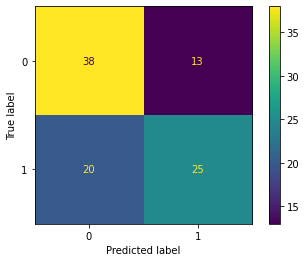

In [23]:
plot_confusion_matrix(modelo_decision_tree, x_teste, y_teste);

Na matriz acima temos os **valores verdadeiros** em função dos **valores preditos**, em uma classificação binária. Por exemplo, se o valor verdadeiro é $1$ e o modelo predice $0$, então soma um no elemento da matriz, se o valor verdadeiro é $0$ e o modelo predice $0$ então soma um no elemento da matriz. Assim temos exatamente quantos foram preditos corretamente na diagonal principal.

A matriz de confusão ajuda a entender melhor o impacto de cada acerto e erro do modelo. Por exemplo 

> Qual o impacto do modelo dizer que **um paciente não precisa** de um leito de UTI **dado que ele precisa?**

> Qual o impacto do modelo dizer que **um paciente precisa** de um leito de UTI **dado que ele precisa?** 

> Qual o impacto do modelo dizer que **um paciente precisa** de um leito de UTI **dado que ele não precisa?** 

> Qual o impacto do modelo dizer que **um paciente não precisa** de um leito de UTI **dado que ele não precisa?** 

No caso do problema do hopital o impacto de não encaminhar um paciente para a UTI dado que ele precisa do serviço é extremamente grave pois o paciente pode retonar para a casa e isso pode agravar a situação ao ponto dele não conseguir voltar ao hospital. A penalidade de perder uma vida tende ao infinito, neste caso.

Na matriz de confusão a acurácia é representada na razão entre a soma dos elementos da diagonal principal pela soma de todos os elementos. Então a ideia no problema do hospital é tentar reduzir o máximo a situação em que o modelo não encaminha um paciente para a UTI dado que ele realmente precisa.

/home/conrado/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


CPU times: user 2.09 s, sys: 27.9 ms, total: 2.12 s
Wall time: 1.6 s


Text(0.5, 1.0, 'Decision Tree Classifier')

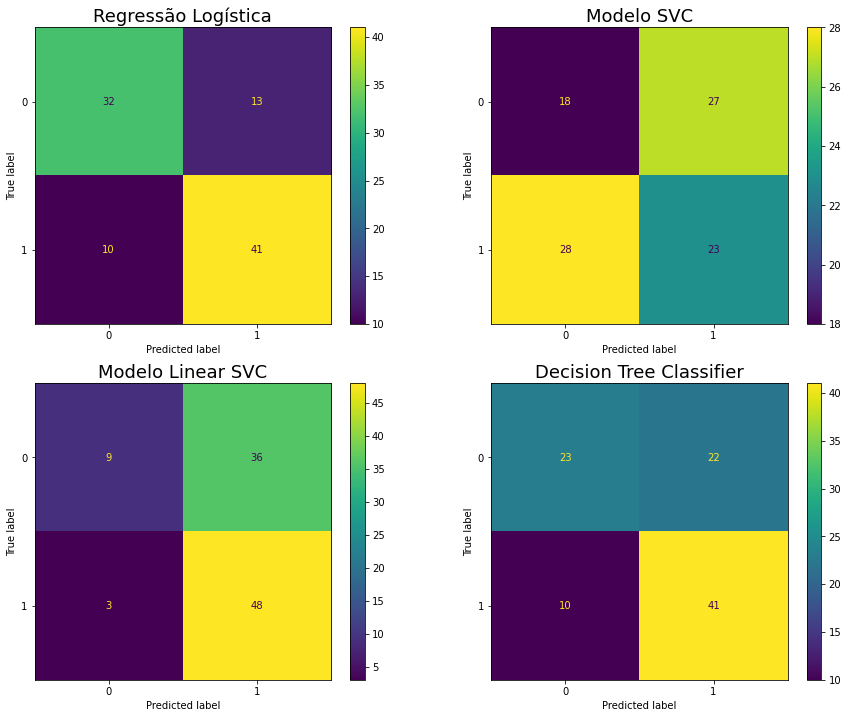

In [24]:
%%time
seed = np.random.seed(9834520)

# Instanciando modelos
modelo_dummy = DummyClassifier(strategy='prior')
modelo_regressao_logistica = LogisticRegression(solver='newton-cg',max_iter=10000)
modelo_svc = SVC(max_iter=10000, kernel='sigmoid')
modelo_linear_svc = LinearSVC(max_iter=10000)
modelo_decision_tree = DecisionTreeClassifier()


# Separação dos dados
x_treino, x_teste, y_treino, y_teste = train_test_split(x,y, random_state=seed)

# Ajuste dos modelos
modelo_dummy.fit(x_treino,y_treino)
modelo_regressao_logistica.fit(x_treino,y_treino)
modelo_svc.fit(x_treino, y_treino)
modelo_linear_svc.fit(x_treino, y_treino)
modelo_decision_tree.fit(x_treino, y_treino)

# Predição dos modelos
y_pred_dummy = modelo_dummy.predict(x_teste)
y_pred_logis = modelo_regressao_logistica.predict(x_teste)
y_pred_svc = modelo_svc.predict(x_teste)
y_pred_linear_svc = modelo_linear_svc.predict(x_teste)
y_pred_decision_tree = modelo_decision_tree.predict(x_teste)


f, ax = plt.subplots(2, 2,figsize=(15,12))

plot_confusion_matrix(modelo_regressao_logistica, x_teste, y_teste,
                      ax = ax[0,0]).ax_.set_title('Regressão Logística', fontsize=18)

plot_confusion_matrix(modelo_svc, x_teste, y_teste,
                      ax=ax[0,1]).ax_.set_title('Modelo SVC', fontsize=18)

plot_confusion_matrix(modelo_linear_svc, x_teste, y_teste,
                      ax=ax[1,0]).ax_.set_title('Modelo Linear SVC', fontsize=18);

plot_confusion_matrix(modelo_decision_tree, x_teste, y_teste,
                      ax=ax[1,1]).ax_.set_title('Decision Tree Classifier', fontsize=18);

Note que a matriz de confusão permite uma análise mais criteriosa do que simplesmente a acurácia, podemos analisar a precisão e revocação também. Em outras palavras:

> **A acurácia permite metrificar qual modelo acerta mais, já a matriz de confusão permite metrificar quem erra menos.**  

Considerando a matriz de confusão com a seguinte forma, quando falamos de precisão e revocação existem alguns termpos que precisam ser definidos:

$$\begin{bmatrix}
    a_{00} & a_{01} \\
    a_{10} & a_{11} \\
\end{bmatrix} = 
\begin{bmatrix}
    \color{blue}{VN} & \color{darkorange}{FN} \\
    \color{darkorange}{FP} & \color{blue}{VP} \\
\end{bmatrix}
$$

> **Verdadeiro Negativo** ($\color{blue}{VN}$): Predição correta, dado que o valor verdadeiro é negativo. (elemento $a_{00}$)

> **Verdadeiro Positivo** ($\color{blue}{VP}$): Predição correta, dado que o valor verdadeiro é positivo. (elemento $a_{11}$)

> **Falso positivo** ($\color{darkorange}{FP}$): Predição errada, dado o valor verdadeiro que é positivo. (elemento $a_{10}$)

> **Falso Negativo** ($\color{darkorange}{FN}$): Predição errada, dado o valor verdadeiro que é negativo. (elemento $a_{01}$)


Vamos analisar essas quantidades referentes à matriz de confusão do modelo de regressão logistica:

In [25]:
vp = 41
vn = 32
fp = 13
fn = 10

In [26]:
from sklearn.metrics import classification_report

```python
sklearn.metrics.classification_report(y_true, y_pred, *, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')
```

`return`:
> Text summary of the precision, recall, F1 score for each class. Dictionary returned if output_dict is True. 

In [27]:
print(classification_report(y_teste, y_pred_decision_tree))

              precision    recall  f1-score   support

           0       0.70      0.51      0.59        45
           1       0.65      0.80      0.72        51

    accuracy                           0.67        96
   macro avg       0.67      0.66      0.65        96
weighted avg       0.67      0.67      0.66        96



Passando o hiperparâmetro `output_dict=True` podemos fornecer a estrutura a um dataframe.

In [28]:
pd.DataFrame(classification_report(y_teste, y_pred_decision_tree,output_dict=True)).T

,precision,recall,f1-score,support
0,0.696970,0.511111,0.589744,45.000000
1,0.650794,0.803922,0.719298,51.000000
accuracy,0.666667,0.666667,0.666667,0.666667
macro avg,0.673882,0.657516,0.654521,96.000000
weighted avg,0.672439,0.666667,0.658570,96.000000


## Classification Report

Na documentação da função `sklearn.metrics.precision_recall_fscore_support`, temos a descrição do que é `precision`, `recall` e o `f1_score`:

> The precision is the ratio `tp / (tp + fp)` where `tp` is the number of true positives and `fp` the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

> The recall is the ratio `tp / (tp + fn)` where `tp` is the number of true positives and `fn` the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

> The `F-beta score` can be interpreted as **a weighted harmonic mean of the precision and recall**, where an `F-beta score` reaches its best value at 1 and worst score at 0.

> The `F-beta score` weights recall more than precision by a factor of beta. `beta == 1.0` means recall and precision are equally important.

> The support is the number of occurrences of each class in `y_true`.

Temos então que a acurácia é um indicador de acerto do modelo, sejá este acerto um verdadeiro positivo ou um verdadeiro negativo. Já a **precisão, como já foi dito acima, é um indicador da capacidade do modelo acertar, ou seja, de não rotular um como positivo algo que é negativo**.

Por outro lado, o recall, também conhecido como revocação é basicamente o simétrico da precisão. **Recall é um indicador da capacidade do modelo não rotular como falso algo que é positivo**. A imagem a seguir pode ajudar a ilustrar o significado de cada métrica

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/320px-Precisionrecall.svg.png' width=40%>

Outra métrica indicada no `precision_recall_fscore_support` é o `F-beta Score`. Este indicador é uma média harmônica ponderada da precisão e da revocação. F-beta varia de 0 até 1, sendo o valor máximo um indicador de que a precisão e a revocação são igualmente importantes. O cálculo do $f_\beta$ é realizado da seguinte maneira:

$$ f_\beta = \frac{2 (p \times r)}{ p + r}.$$

Uma característica de uma média harmônica é representar duas quantidade de acordo com uma única medida, logo se a média harmônica da precisão $p$ e do recall $r$ esta baixa (próxima de $0$), siginifca que uma das duas quantidade esta baixa. Ao passo que se as duas estão altas o valor é alto, veja um exemplo:


In [30]:
def f_beta(p, r):
    return (2*(p*r)) / (p + r)


p1,p2,p3 = 0.5, 0.9, 1.0
r1,r2,r3 = 0.5, 0.5, 0.3

print('f_beta(p,r) = média harmonica ponderada')
print(f'f_beta({p1},{r1}) = {f_beta(p1,r1):.2f}')
print(f'f_beta({p2},{r2}) = {f_beta(p2,r2):.2f}')
print(f'f_beta({p3},{r3}) = {f_beta(p3,r3):.2f}')

f_beta(p,r) = média harmonica ponderada
f_beta(0.5,0.5) = 0.50
f_beta(0.9,0.5) = 0.64
f_beta(1.0,0.3) = 0.46


> Note que se $p$ e $r$ são próximos, então $f_\beta$ é próximo, entretanto se um valor é alto e o outro é baixo, a tendência do $f_\beta$ é ir em direção ao valor mais baixo.

Além disso existem outras implementações da propria métrica F-Score, alguns métodos conseguem dar um peso maior para a precisão ou para o recall.



### Utilidade das métricas

A precisão e revocação fornecem uma informação muito mais refinada a respeito de um modelo e são de suma importancia dependendo do problema que a equipe busca selecionar. Por exemplo, gestores de seguros, quando fazem uma análise de risco com respeito de um cliente podem levar em conta geralmente a precisão das estimativas, entretanto pro mercado de seguros em si não é tão relevante o quanto a empresa acerta, mas sim o quanto ela erra.

Corretora de valores imobiliarios também, gerentes de fundos podem estar muito mais interessados na revocação de um modelo que preve investimentos a longo prazo mais do que nos ganhos em si, porque o objetivo não é só ganhar dinheiro, mas evitar de perder. 

Em geral todos os problemas cuja análise do resultado pode ser condensada na frase

> **Errar pouco em algumas situações é melhor do que acertar muito**,

utiliza-se a revocação (*recall*). No objetivo deste trabalho por exemplo, a importancia de não se deparar com um falso negativo é extremamente relevante e pode ajudar a salvar vidas, pois estimar que um paciente não precisa de UTI dado que ele precisa pode leva-lo a óbito.

## Exibindo arvore de decisão

Um dos modelo utilizados é o `DecisionTreeClassifier`, que é basicamente uma árvore de seleção binária que classifica os elementos de acordo com algum índice, por exemplo o indice de Gini. Esse classificar é um dos poucos que pode ser uma etapa interessante analisar os criérios de seleção do modelo.

Para visualizar a árvore de decisão vamos utilizar um módulo do python chamado [**GraphViz**](https://graphviz.org/). Com ele é possível visualizar a árvore de decisão do modelo, isso porque o `SKlearn` tem uma forma de exportar o modelo para uma visualização do GraphViz

In [31]:
import graphviz
from sklearn.tree import export_graphviz

É importante salientar que o modelo do Sirio Libanes fornece mais de 200 features, portanto é inviável visualizar todas. Dito isso, vou selecionar apenas as features no quesito `DISEASE GROUPING`:

In [57]:
dot_data = export_graphviz(modelo_decision_tree, out_file=None,
                           filled = True, rounded = True,
                           feature_names = x.columns,
                           class_names=['Não Precisa de UTI', 'Precisa de UTI '],rotate=True)

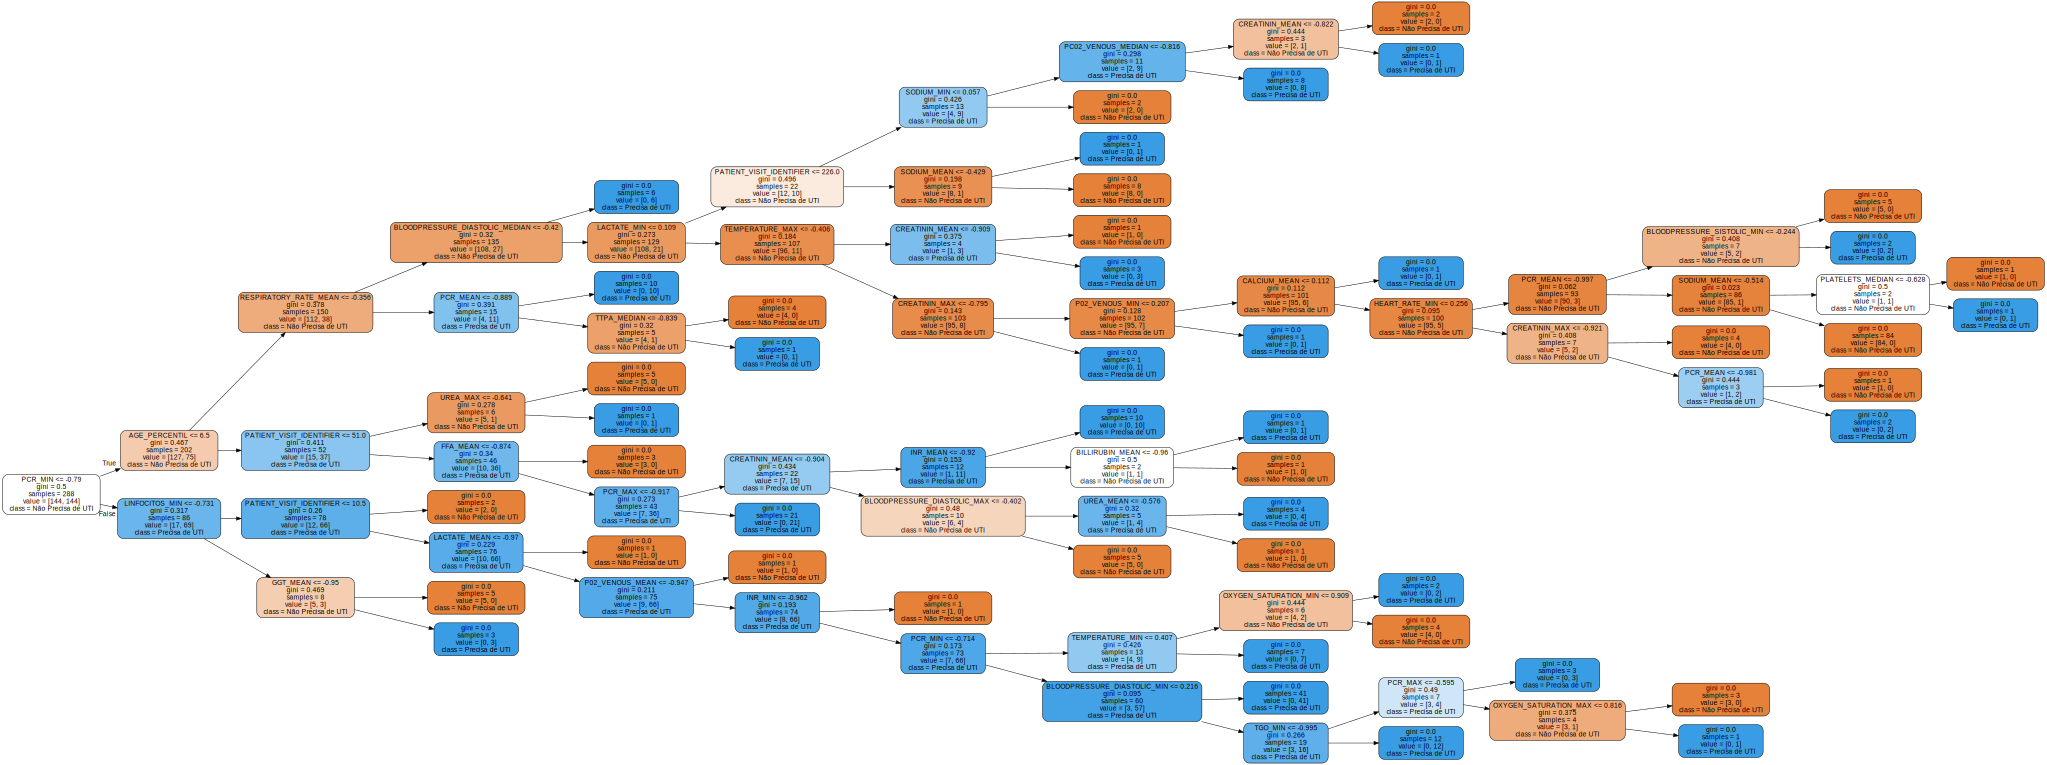

In [58]:
grafico = graphviz.Source(dot_data)
grafico

Esta árvore é extremamente grande e pode ser um tanto complexo interpreta-la. O módulo `pydotplus` permite manipular o tamanho da árvore do graphviz:

In [59]:
import pydotplus

In [60]:
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
#pydot_graph.write_png('Tamanho_Original.png')
#pydot_graph.set_size('"5,5!"')
#pydot_graph.write_png('resized_tree.png')

True